# 1. Install Dependencies

In [ ]:
!pip install gym[atari]
!pip install numpy
!pip install keras==2.1.2
!pip install tensorflow 1.15.5

# 2. Import Dependencies

In [1]:
import numpy as np
# import _pickle as pickle
import gym
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.optimizers import rmsprop
import keras.backend as K

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# 3. Create The Enviorment

In [2]:
env = gym.make('PongDeterministic-v4')
action_space = [4,5] #[No-op, up, down]

# 4. Create Discounted Reward

In [3]:
gamma = 0.99
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(discounted_r))):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add =  r[t] + running_add * gamma # belman equation
        discounted_r[t] = running_add
    return discounted_r

def discount_n_standardise(r):
    dr = discount_rewards(r)
    dr = (dr - dr.mean()) / dr.std()
    return dr

# 5. Prepare The Image

In [4]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 80x80x1 float """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)[:,:,None]

# 6. Create The Machine Learning Model

In [5]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3,3), padding='same', activation='relu', input_shape = (80,80,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(12, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(len(action_space), activation='softmax'))
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') #

model.summary()





Instructions for updating:
keep_dims is deprecated, use keepdims instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 12)        876       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 12)        0         
_______________________________________________________________

# 7. Train the Model

In [15]:
episodes = 0
n_episodes = 1000
reward_sums = np.zeros(n_episodes)
losses = np.zeros(n_episodes)
time_taken = np.zeros(n_episodes)
reward_sum = 0
input_shape = (80, 80, 1)

prev_x = None
buffer = 1000
xs = np.zeros((buffer,)+input_shape)
ys = np.zeros((buffer,1))
rs = np.zeros((buffer))

k = 0

observation = env.reset()

while episodes < n_episodes:
    # Get the current state of environment
    x = prepro(observation)
    xs[k] = x - prev_x if prev_frame is not None else np.zeros(input_shape)
    prev_x = x
    
    # Take an action given current state of policy model
    p = model.predict(xs[k][None,:,:,:])
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    ys[k] = a
    
    # Renew state of environment
    observation, reward, done, _ = env.step(action)
    reward_sum += reward #record total rewards
    rs[k] = reward # record reward per step
    
    k += 1
    
    if done or k==buffer:
        reward_sums[episodes] = reward_sum
        reward_sum = 0
        
        # Gather state, action (y), and rewards (and preprocess)
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        ep_r = discount_n_standardise(ep_r)
        
        model.fit(ep_x, ep_y, sample_weight=ep_r, batch_size=512, epochs=1, verbose=0)
        
        time_taken[episodes] = k
        k = 0
        prev_x = None
        observation = env.reset()
        losses[episodes] = model.evaluate(ep_x, 
                                          ep_y,
                                          sample_weight=ep_r,
                                          batch_size=len(ep_x), 
                                          verbose=0)
        episodes += 1
        
        # Print out metrics like rewards, how long each episode lasted etc.
        if episodes%(n_episodes//20) == 0:
            ave_reward = np.mean(reward_sums[max(0,episodes-200):episodes])
            ave_loss = np.mean(losses[max(0,episodes-200):episodes])
            ave_time = np.mean(time_taken[max(0,episodes-200):episodes])
            print('Episode: {0:d}, Average Loss: {1:.4f}, Average Reward: {2:.4f}, Average steps: {3:.4f}'
                  .format(episodes, ave_loss, ave_reward, ave_time))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Episode: 50, Average Loss: -0.0062, Average Reward: -18.7600, Average steps: 950.8400
Episode: 100, Average Loss: -0.0087, Average Reward: -18.1200, Average steps: 957.3000
Episode: 150, Average Loss: -0.0099, Average Reward: -17.5867, Average steps: 965.2933
Episode: 200, Average Loss: -0.0115, Average Reward: -17.2250, Average steps: 970.0950
Episode: 250, Average Loss: -0.0136, Average Reward: -16.2100, Average steps: 979.2450
Episode: 300, Average Loss: -0.0155, Average Reward: -15.3650, Average steps: 987.1350
Episode: 350, Average Loss: -0.0215, Average Reward: -14.7000, Average steps: 986.8400
Episode: 400, Average Loss: -0.0248, Average Reward: -15.3300, Average steps: 956.9450
Episode: 450, Average Loss: -0.0316, Average Reward: -14.1200, Average steps: 960.035

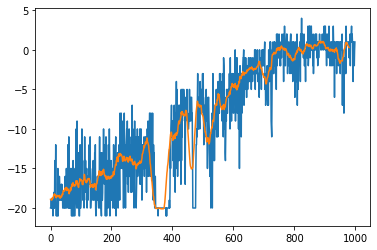

In [24]:
window = 20
plt.plot(reward_sums[:episodes])
plt.plot(np.convolve(reward_sums[:episodes], np.ones((window,))/window, mode='valid'))
plt.savefig("keras_1000ep.jpg")
plt.show()


In [20]:
observation = env.reset()
cum_reward = 0
frames = []
prev_frame = None
for t in range(100000):
    x = prepo(observation) 
    diff = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    p = model.predict(diff[None,:,:,:])
    prev_frame = x
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    
    # Render into buffer. 
    env.render()
    observation, reward, done, info = env.step(action)
    if done:
        break
        
# env.render(close=True)


In [21]:
env.close()